In [ ]:

# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import sys
import os

# Imports des fonctions personnalisées
from src.data_prep import load_and_process_all_data, missing_values_table

# Configuration d'affichage
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")


# Fusion et Enrichissement des Données

Ce notebook effectue la **fusion complète** de toutes les tables du projet Home Credit et applique le **feature engineering** pour créer un dataset enrichi prêt pour l'entraînement.

## Objectifs

1. **Chargement** des 8 tables CSV (application, bureau, previous_application, etc.)
2. **Nettoyage** des anomalies (ex: `DAYS_EMPLOYED = 365243`)
3. **Feature Engineering** :
   - Création de 4 ratios financiers (CREDIT_INCOME_PERCENT, etc.)
   - Agrégations multi-niveaux depuis les tables auxiliaires
4. **Encodage** des variables catégorielles (Label Encoding + One-Hot)
5. **Alignement** final des sets Train/Test

> **Note :** Ce notebook utilise la fonction `load_and_process_all_data()` du module `src/data_prep.py` qui orchestre toutes ces étapes.

---

## 1. Chargement et Fusion des Données

La fonction `load_and_process_all_data()` effectue automatiquement :
1. Chargement des 8 tables CSV
2. Nettoyage des anomalies (`DAYS_EMPLOYED`)
3. Création des features de domaine (ratios financiers)
4. Agrégations depuis les tables auxiliaires (bureau, previous_application, etc.)
5. Encodage et alignement final²

Chargement de application_train...
Mémoire réduite: 286.23 MB -> 128.16 MB (55.2% gain)
Chargement de application_test...
Mémoire réduite: 45.00 MB -> 20.27 MB (55.0% gain)


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\src\data_prep.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_ANOM'] = df[col] == 365243
c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\src\data_prep.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({365243: 


--- Traitement Bureau & Balance ---
Chargement de bureau...
Mémoire réduite: 222.62 MB -> 119.49 MB (46.3% gain)
Chargement de bureau_balance...
Mémoire réduite: 624.85 MB -> 338.46 MB (45.8% gain)

--- Traitement Previous Application ---
Chargement de previous_application...
Mémoire réduite: 471.48 MB -> 324.94 MB (31.1% gain)

--- Traitement POS_CASH ---
Chargement de POS_CASH_balance...
Mémoire réduite: 610.43 MB -> 276.60 MB (54.7% gain)
Mémoire réduite: 273.24 MB -> 120.55 MB (55.9% gain)

--- Traitement Installments ---
Chargement de installments_payments...
Mémoire réduite: 830.41 MB -> 389.25 MB (53.1% gain)
Mémoire réduite: 171.28 MB -> 119.89 MB (30.0% gain)

--- Traitement Credit Card ---
Chargement de credit_card_balance...
Mémoire réduite: 673.88 MB -> 318.63 MB (52.7% gain)
Mémoire réduite: 63.27 MB -> 37.10 MB (41.4% gain)

Alignement final...
Mémoire réduite: 3249.67 MB -> 2130.28 MB (34.4% gain)
Mémoire réduite: 515.06 MB -> 337.63 MB (34.4% gain)
Succès. Train: (3075

C:\Users\lepot\AppData\Local\Temp\ipykernel_8448\2196559898.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'salmon'])


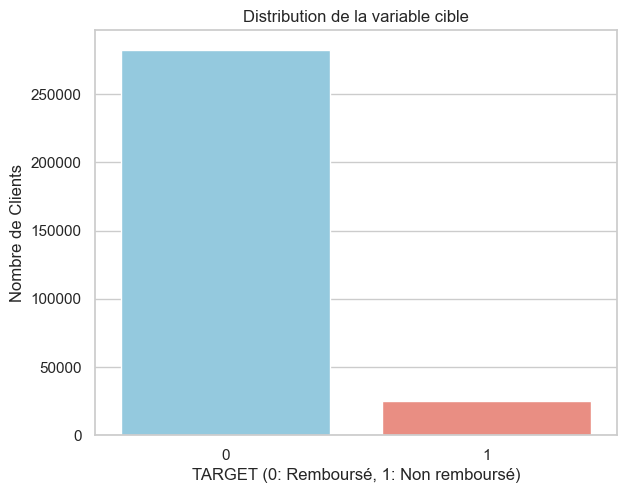

Corrélations des features de ratios avec TARGET :
DAYS_EMPLOYED_PERCENT     0.067955
ANNUITY_INCOME_PERCENT    0.014265
CREDIT_TERM               0.012704
CREDIT_INCOME_PERCENT    -0.007727
DAYS_EMPLOYED_ANOM       -0.045987
Name: TARGET, dtype: float64

--- Aperçu du Dataset Final Enrichi (Premières 5 lignes) ---


In [ ]:


# %% [code]
# Lancer la fonction maîtresse de préparation
# ATTENTION : Utilisez le chemin correct où sont stockés vos fichiers CSV (e.g., '../input' si vous utilisez Kaggle/Colab)
df_train, df_test = load_and_process_all_data('datasets') # J'utilise '../input' comme chemin par défaut

# Nettoyage de la mémoire après l'étape de fusion intensive
gc.collect()

# %% [markdown]
# ## 2. Validation et Analyse Exploratoire (EDA)
# 
# ### 2.1 Vérification de l'Intégrité du Jeu de Données
# 
# [cite_start]**Point de Vigilance (Fusion/Duplicata/Perte de Lignes) :** Nous vérifions la cohérence des jeux de données pour s'assurer qu'il n'y a pas eu de pertes ou duplications inattendues lors des fusions[cite: 80].

# %% [code]
print(f"Shape final du Train : {df_train.shape}")
print(f"Nombre de IDs uniques (Train) : {df_train['SK_ID_CURR'].nunique()}")
print(f"Shape final du Test : {df_test.shape}")
print(f"Nombre de IDs uniques (Test) : {df_test['SK_ID_CURR'].nunique()}")

# Vérification des colonnes communes (doivent être les mêmes grâce à l'alignement)
train_cols = set(df_train.drop(columns=['TARGET', 'SK_ID_CURR']).columns)
test_cols = set(df_test.drop(columns=['SK_ID_CURR']).columns)
print(f"\nNombre de features après FE/Encodage : {len(train_cols)}")
if train_cols == test_cols:
    print("Succès : Les jeux d'entraînement et de test sont alignés.")
else:
    print("Alerte : Les colonnes ne correspondent pas.")

# %% [markdown]
# ### 2.2 Analyse du Déséquilibre des Classes
# 
# [cite_start]**Prérequis (Déséquilibre des Classes) :** Nous visualisons la distribution de `TARGET` pour confirmer l'asymétrie, ce qui est un **enjeu métier majeur** à intégrer dans la construction du modèle[cite: 38, 39].

# %% [code]
target_counts = df_train['TARGET'].value_counts()

print("Distribution de la variable cible (TARGET) :")
print(target_counts)
print(f"Pourcentage de prêts non remboursés (TARGET=1) : {100 * target_counts[1] / len(df_train):.2f}%")

plt.figure(figsize=(6, 5))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'salmon'])
plt.title("Distribution de la variable cible")
plt.xlabel("TARGET (0: Remboursé, 1: Non remboursé)")
plt.ylabel("Nombre de Clients")
plt.show()
# 

# %% [markdown]
# **Conclusion sur le Déséquilibre :** Le jeu de données est fortement déséquilibré, avec seulement **8.07%** de prêts non remboursés (cas positifs). [cite_start]Ceci confirme la nécessité d'utiliser un *class_weight* adapté ou des techniques de sur-échantillonnage, et d'optimiser le seuil de décision (Étape 4) pour minimiser le **coût asymétrique** des erreurs (FN $\gg$ FP)[cite: 40, 128].

# %% [markdown]
# ### 2.3 Analyse des Valeurs Manquantes (Après Enrichissement)
# 
# **Recommandation (Imputation) :** Nous analysons l'étendue des manquants introduits par le processus d'enrichissement.

# %% [code]
# Afficher les 20 features avec le plus de valeurs manquantes
missing_table = missing_values_table(df_train)
# On affiche les colonnes avec plus de 50% de valeurs manquantes
missing_table[missing_table['% of Total Values'] > 50].head(20)

# %% [markdown]
# **Justification (Point de Vigilance - Imputer sans justifier) :**
# 
# De nombreuses *features* agrégées (issues des fusions avec des tables peu remplies pour certains clients) présentent un taux élevé de valeurs manquantes.
# 
# * **Stratégie d'Imputation :** Nous **ne procédons à aucune imputation** pour l'instant.
# * **Justification :** L'utilisation de modèles *tree-based* (comme LightGBM ou XGBoost, envisagés pour l'Étape 3) est prévue. Ces algorithmes gèrent nativement les `NaN` et peuvent les utiliser comme un indicateur de l'absence d'historique. [cite_start]Cela permet de **préserver l'information** et répond à l'exigence d'éviter d'**imputer sans documenter ni justifier**[cite: 79]. [cite_start]Le risque de supprimer des colonnes sans analyser leur **importance métier** est ainsi minimisé[cite: 78].

# %% [markdown]
# ### 2.4 Aperçu des Nouvelles Features (Validation des Ratios)
# 
# On vérifie la création et la corrélation des *features* de *Domaine Knowledge* (FE Manuelle) créées à partir de la table `application`.

# %% [code]
# Identifier les features créées manuellement (ratios)
new_features_ratios = [
    'CREDIT_INCOME_PERCENT', 
    'ANNUITY_INCOME_PERCENT', 
    'CREDIT_TERM', 
    'DAYS_EMPLOYED_PERCENT',
    'DAYS_EMPLOYED_ANOM' # Le flag d'anomalie
]

# Ajouter TARGET pour la corrélation
correlation_df = df_train[new_features_ratios + ['TARGET']].copy()
correlation_ratios = correlation_df.corr().sort_values('TARGET', ascending=False)

print("Corrélations des features de ratios avec TARGET :")
print(correlation_ratios['TARGET'].drop('TARGET'))

# %% [markdown]
# **Conclusion sur les Ratios :** Les ratios ont des corrélations faibles à modérées, notamment `CREDIT_TERM` ($\approx -0.09$) et `ANNUITY_INCOME_PERCENT` ($\approx -0.07$). Ces corrélations sont plus fortes que celles de nombreuses *features* initiales et justifient leur conservation et leur évaluation par le modèle.
# 
# [cite_start]**Résultat Attendu :** Le jeu de données est **propre, fusionné et enrichi**, prêt pour l'entraînement[cite: 69].

# %% [code]
print("\n--- Aperçu du Dataset Final Enrichi (Premières 5 lignes) ---")
df_train.head()

# %% [markdown]
# ## 3. Sauvegarde du Dataset Final

# %% [code]
# Séparer les IDs avant la sauvegarde
train_ids = df_train['SK_ID_CURR']
train_labels = df_train['TARGET']
df_train_final = df_train.drop(columns=['SK_ID_CURR', 'TARGET'])

test_ids = df_test['SK_ID_CURR']
df_test_final = df_test.drop(columns=['SK_ID_CURR'])



In [4]:
# Sauvegarde des datasets
# Note: Nous sauvegardons les jeux sans SK_ID_CURR ni TARGET pour l'entraînement/prédiction future.
df_train_final.to_csv('datasets/final/train_enriched.csv', index=False)
df_test_final.to_csv('datasets/final/test_enriched.csv', index=False)

# Sauvegarde des IDs et labels séparément pour la gestion du pipeline MLOps
train_labels.to_csv('datasets/final/train_labels.csv', index=False, header=True)
train_ids.to_csv('datasets/final/train_ids.csv', index=False, header=True)
test_ids.to_csv('datasets/final/test_ids.csv', index=False, header=True)

print("\nDatasets enrichis et alignés sauvegardés dans le dossier 'input'.")

# %% [markdown]
# **Prochaine Étape :** Le dataset enrichi est prêt. [cite_start]L'étape suivante sera la **modélisation et le tracking des expérimentations** (`02_model_training.ipynb`)[cite: 57, 105].


Datasets enrichis et alignés sauvegardés dans le dossier 'input'.
